## Don't Get Kicked!



**Problem description**

One of the biggest challenges of an auto dealership purchasing a used car at an auto auction is the risk of that the vehicle might have serious issues that prevent it from being sold to customers. The auto community calls these unfortunate purchases "kicks".

Kicked cars often result when there are tampered odometers, mechanical issues the dealer is not able to address, issues with getting the vehicle title from the seller, or some other unforeseen problem. Kick cars can be very costly to dealers after transportation cost, throw-away repair work, and market losses in reselling the vehicle.

Modelers who can figure out which cars have a higher risk of being kick can provide real value to dealerships trying to provide the best inventory selection possible to their customers.

The goal of this project is to predict if the car purchased at the Auction is a Kick (bad buy).

Data source https://www.kaggle.com/c/DontGetKicked/data?select=training.csv. Only training data used since it contains labels of the target (bad buy or not).

In [ ]:
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None
#from catboost import CatBoostClassifier
#from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
#from sklearn.metrics import accuracy_score

#Pipeline
#from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.compose import make_column_transformer
from imblearn.pipeline import Pipeline,make_pipeline

#For Missing Value and Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE


from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
%matplotlib inline
import time
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score,roc_curve, auc,accuracy_score,roc_auc_score,precision_recall_curve
from sklearn.metrics import classification_report


#Importing all libraries
import sklearn
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix

!pip install sweetviz
import sweetviz as sv
!pip install phik
import phik
from phik import resources, report
import matplotlib.pyplot as plt
#
!pip install category_encoders
import category_encoders

!pip install shap
import shap
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#!pip install scikit-optimize
#from skopt import BayesSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.5 MB/s eta 0:00:00


In [ ]:
#!pip install scikit-optimize
#from skopt import BayesSearchCV

## Load data and EDA

In [ ]:
df = pd.read_csv('training.csv')

In [ ]:
df

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,73010,1,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,...,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
72979,73011,0,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,...,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
72980,73012,0,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,...,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893
72981,73013,0,12/2/2009,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,...,10099.0,11228.0,NaN,NaN,18881,30212,GA,7000.0,0,1974


In [ ]:
# check the descriptive statsitics of the numerical features
df.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,72983.000000,72983.000000,72983.000000,69814.000000,72983.000000,72965.000000,72965.000000,72965.000000,72965.000000,72668.000000,72668.000000,72668.000000,72668.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,36511.428497,0.122988,2005.343052,4.176644,1.494299,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,26345.842155,58043.059945,6730.934326,0.025280,1276.580985
std,21077.241302,0.328425,1.731252,1.712210,0.521290,14578.913128,2461.992768,2722.491986,3156.285284,3385.789541,2434.567723,2686.248852,3090.702941,3310.254351,25717.351219,26151.640415,1767.846435,0.156975,598.846788
min,1.000000,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,18257.500000,0.000000,2004.000000,3.000000,1.000000,61837.000000,4273.000000,5406.000000,6280.000000,7493.000000,4275.000000,5414.000000,6536.000000,7784.000000,17212.000000,32124.000000,5435.000000,0.000000,837.000000
50%,36514.000000,0.000000,2005.000000,4.000000,1.000000,73361.000000,6097.000000,7303.000000,8444.000000,9789.000000,6062.000000,7313.000000,8729.000000,10103.000000,19662.000000,73108.000000,6700.000000,0.000000,1155.000000
75%,54764.500000,0.000000,2007.000000,5.000000,2.000000,82436.000000,7765.000000,9021.000000,10651.000000,12088.000000,7736.000000,9013.000000,10911.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,73014.000000,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,45469.000000,1.000000,7498.000000


In [ ]:
df.shape

(72983, 34)

In [ ]:
df.isna().sum()/len(df)

IsBadBuy                             0.000000
Auction                              0.000000
VehYear                              0.000000
VehicleAge                           0.000000
Make                                 0.000000
Model                                0.000000
Trim                                 0.032337
SubModel                             0.000110
Color                                0.000110
Transmission                         0.000123
WheelType                            0.043491
VehOdo                               0.000000
Nationality                          0.000069
Size                                 0.000069
TopThreeAmericanName                 0.000069
MMRAcquisitionAuctionAveragePrice    0.000247
MMRAcquisitionAuctionCleanPrice      0.000247
MMRAcquisitionRetailAveragePrice     0.000247
MMRAcquisitonRetailCleanPrice        0.000247
MMRCurrentAuctionAveragePrice        0.004316
MMRCurrentAuctionCleanPrice          0.004316
MMRCurrentRetailAveragePrice      

In [ ]:
df.dtypes

RefId                                  int64
IsBadBuy                               int64
PurchDate                             object
Auction                               object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrent

Generate EDA report using auto EDA tool

In [ ]:

# indicate the depedendent variable
my_report = sv.analyze(df, target_feat='IsBadBuy')
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


The sweetivz report (SWEETVIZ_REPORT_0119.html) can be found in the folder as well.  

## Insights from EDA


* Target variable: "IsBadBuy" is imbalanced with 12% labeled as 1 and 88% labeled as 0. Techniques such as random down sampling, SMOTE imputation, or use class weights balanced during training can be utilized.

* Missing values:

  * "PRIMEUNIT" (the level of demand with respect to a standard purchase) and "AUCGUART" (describes the risk that can be run with the vehicle) have over 95% missing values. Due to the high percentage of missing data, these columns will be dropped.
  * For other columns with small to moderate missing values, imputation techniques can be applied.

* Drop ID and unuseful columns (for now):

  * "RefId," "PurchDate," and "BYRNO" will be dropped.
  * "WheelTypeID" will be dropped since it represents the ID of the wheel type.
  * "VNZIP1" will be dropped as it represents the ZIP code. "VNST" (US state) will be kept as it provides more general information.

* High correlations:

  * The "MMR.." features, which describe different cost types associated with each vehicle, exhibit high correlation. To address this, a new feature called "avg_MMR" will be created, containing the mean of all these features.
  * "VehYear" and "VehicleAge" are highly correlated. Since the age of the vehicle is already captured by "VehicleAge," only "VehicleAge" will be kept.
  * Categorical features such as "Make," "Model," "Trim," and "SubModel" represent the brand characteristics of the vehicle. To simplify the model, only "Make" and "Trim" will be retained. Additionally, categories within "Make" will be collapsed.

* Transmission contains one observation labeled as 'Manual', which will be recoded as 'MANUAL'.

* Outliers:

  * The distributions of "MMR.." features, "WarrantyCost," and "VehBCost" are skewed, indicating the presence of extreme values. These variables can be capped based on predefined thresholds to handle outliers.

  * "VehicleAge" contains two observations with a value of zero but large "VehOdo." These observations raise suspicions of odometer tampering.

* "VehOdo" is related to "VehicleAge." To capture the nonlinear relationship, a new feature called "miles_per_year" will be created to differentiate between heavily and lightly used cars.

In [ ]:
#print(df[df['WheelType'].isna()==True]['Model'].value_counts(normalize=True))
#df.Model.value_counts(normalize=True)

In [ ]:
drop_col=['RefId','PurchDate','WheelTypeID','PRIMEUNIT','AUCGUART','VNZIP1']
df.drop(drop_col,inplace=True,axis=1)

In [ ]:
# check for phi k correlations (among different types of features)
phik_overview=df.phik_matrix()

interval columns not set, guessing: ['IsBadBuy', 'VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Model is large: 1063. Are you sure this is not an interval variable? Analysis for pairs of variables including Model can be slow.
  warnings.warn(


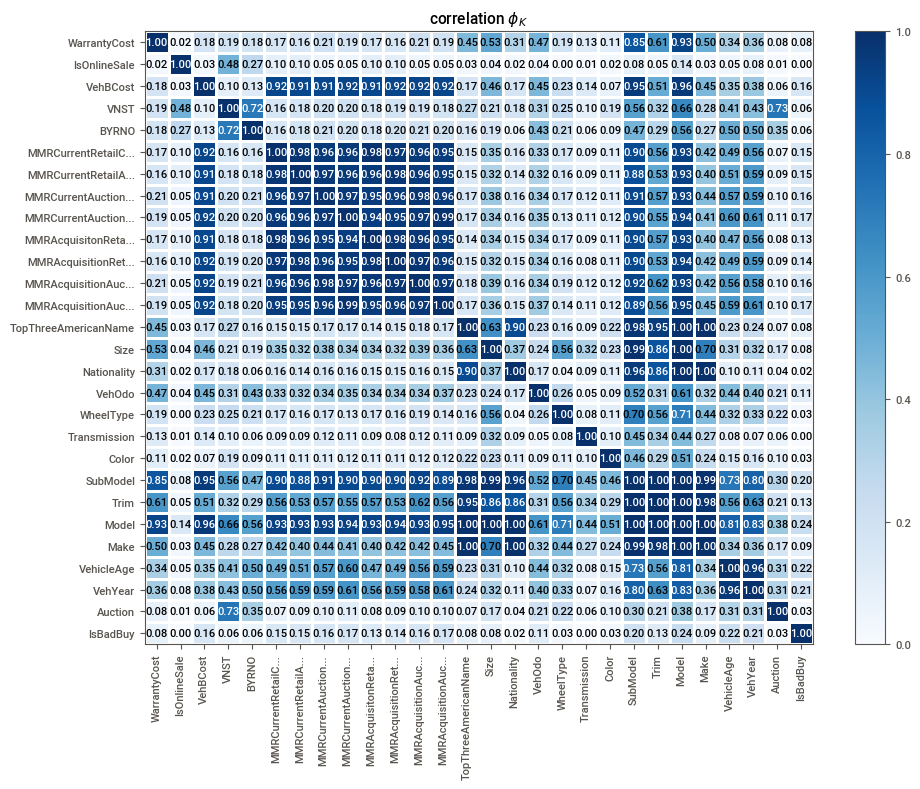

In [ ]:
# display phi k correlation coefficients
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=0.8,
                        figsize=(10,8))
plt.tight_layout()

It looks like VehBCost, MMR...features, Trim, Model, subModel and VehicleAge are relatvely strong features to determine whether a purchase at auction is bad buy or not.  

## Preprocess & Feature Engineering

In [ ]:
df.columns

Index(['IsBadBuy', 'Auction', 'VehYear', 'VehicleAge', 'Make', 'Model', 'Trim',
       'SubModel', 'Color', 'Transmission', 'WheelType', 'VehOdo',
       'Nationality', 'Size', 'TopThreeAmericanName',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO',
       'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost'],
      dtype='object')

In [ ]:
cat_cols = [  'TopThreeAmericanName', 'Color', 'Transmission',
                 'Nationality', 'Size']


num_cols =  ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']

res_cols=['Auction',  'IsOnlineSale', 'Make',  'VNST',
        'VehOdo', 'VehicleAge','WheelType','Trim','WarrantyCost','VehBCost']

 # assign 2 instance where 'VehicleAge'=0 to 1
df['VehicleAge']=np.where(df.VehicleAge==0,1,df.VehicleAge)

In [ ]:

class Preprocessor(object):
    '''Class used to fill missing, transform outliers and create new MMR_avg and miles_per_year features'''


    def outlier_detector1(self,X,y=None): # for MMR... features
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        lower_bound=q1 - (1.5 * iqr)
        upper_bound=q3 + (1.5 * iqr)
        return lower_bound, upper_bound

    def outlier_detector2(self,X,y=None):  # for 'WarrantyCost' and 'VehBCost'
        X = pd.Series(X).copy()
        lower_bound=X.quantile(0.01)
        upper_bound=X.quantile(0.99)
        return lower_bound, upper_bound

    def avg_MMR_price(self,X,y=None):
         '''
        This function takes the average of the 8 variables of the auction average prices
        '''
         df=X.copy()
         MMR_averages = ['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                        'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
                        'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
                        'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice']


         df['MMR_avg'] = sum(df[ave] for ave in  MMR_averages) /len( MMR_averages)
         df.drop(MMR_averages, axis=1,inplace=True)
         return df


    def fit(self,X,y=None):
        df = X.copy()
        df_num= df[num_cols]
        df_cat=df[cat_cols]
        self.means = df_num.mean()
        self.mod=df_cat.mode()
        self.cat_Make = df['Make'].value_counts().index[:15]
        self.lower_bound=[]
        self.upper_bound=[]
        for col in num_cols:
            self.lower_bound.append(self.outlier_detector1(df_num[col])[0])
            self.upper_bound.append(self.outlier_detector1(df_num[col])[1])
        self.lower_bound_WC=self.outlier_detector2(df['WarrantyCost'])[0]
        self.upper_bound_WC=self.outlier_detector2(df['WarrantyCost'])[1]
        self.lower_bound_VC=self.outlier_detector2(df['VehBCost'])[0]
        self.upper_bound_VC=self.outlier_detector2(df['VehBCost'])[1]



    def transform(self,X,y=None):
        df = X.copy()
        df_num= df[num_cols]
        df_cat=df[cat_cols]
        #fill missing with mean for numerical features
        df_num= df_num.fillna(self.means)
        # winsorize the data in the MMR features
        for i in range(len(num_cols)):
            df_num[num_cols[i]]=df_num[num_cols[i]].map(lambda x: self.upper_bound[i] if x>self.upper_bound[i] else x)
            df_num[num_cols[i]]=df_num[num_cols[i]].map(lambda x: self.lower_bound[i] if x<self.lower_bound[i] else x)

        df_num=self.avg_MMR_price(df_num)
        # fill missing with mode for part of the categorical features
        df_cat=df_cat.fillna({k: v[0] for k, v in self.mod.to_dict().items()})
        df_res=df[res_cols]

        # winsorize the data in WarrantyCost and VehBCost
        df_res['WarrantyCost']=df_res['WarrantyCost'].map(lambda x: self.upper_bound_WC if x>self.upper_bound_WC else x)
        df_res['WarrantyCost']=df_res['WarrantyCost'].map(lambda x: self.lower_bound_WC if x<self.lower_bound_WC else x)
        df_res['VehBCost']=df_res['VehBCost'].map(lambda x: self.upper_bound_VC if x>self.upper_bound_VC else x)
        df_res['VehBCost']=df_res['VehBCost'].map(lambda x: self.lower_bound_VC if x<self.lower_bound_VC else x)

        df=pd.concat([df_num, df_cat,df_res], axis=1)
        df['miles_per_year']=df['VehOdo']/df['VehicleAge'] #create new feature
        df['WheelType']=df['WheelType'].fillna("Unknown") # fill unknown for missing
        df['Trim']=df['Trim'].fillna("Unknown") # fill unknown for missing
        df.loc[df.Transmission=='Manual', 'Transmission'] = 'MANUAL' #convert 'Manual' to 'MANUAL'
        df.loc[(~df.Make.isin(self.cat_Make)), 'Make'] = 'Other' #collapse categories in Make

        return df

    def fit_transform(self,X,y=None):
        self.fit(X)
        return self.transform(X)

In [ ]:
#create instance of the preprocessor class
prep=Preprocessor()


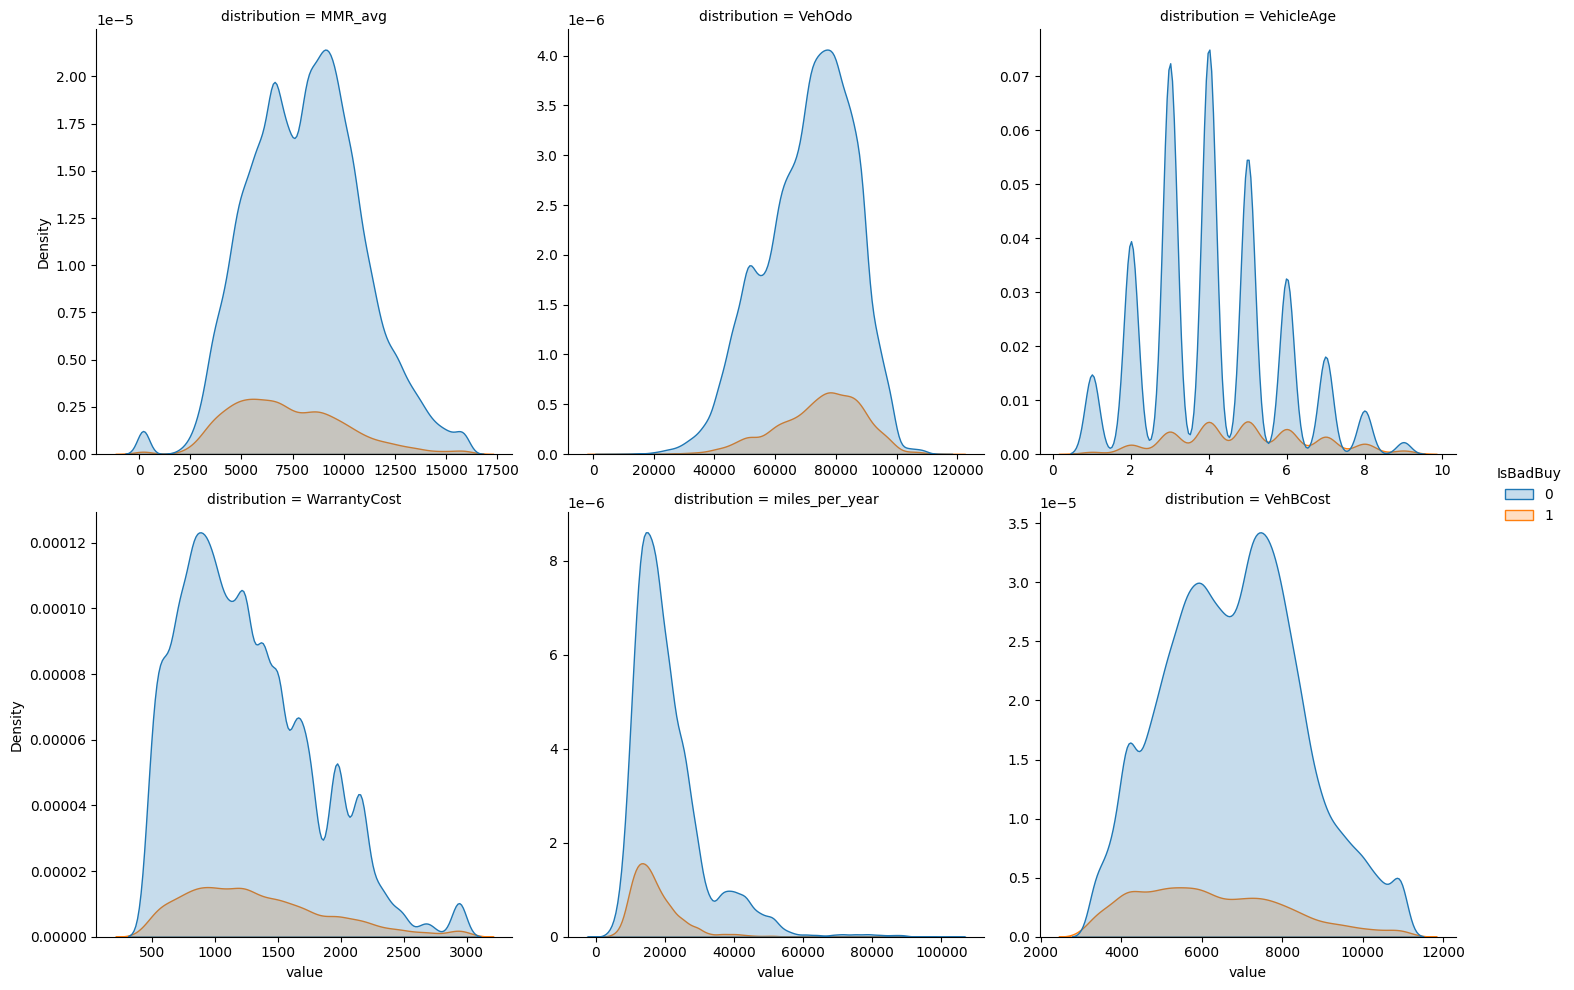

In [ ]:
# Visualize the distributions of numerical features and counts for categorical features by IsBadBuy
#after preprossing

df_clean=pd.concat([prep.fit_transform(df),df['IsBadBuy']],axis=1)
num_features=['MMR_avg','VehOdo',	'VehicleAge',	'WarrantyCost','miles_per_year','VehBCost','IsBadBuy']


dfm = df_clean[num_features].melt(id_vars='IsBadBuy', var_name='distribution')
# plot
sns.displot(kind='kde', data=dfm, col='distribution', col_wrap=3, x='value', hue='IsBadBuy', fill=True, facet_kws={'sharey': False, 'sharex': False})


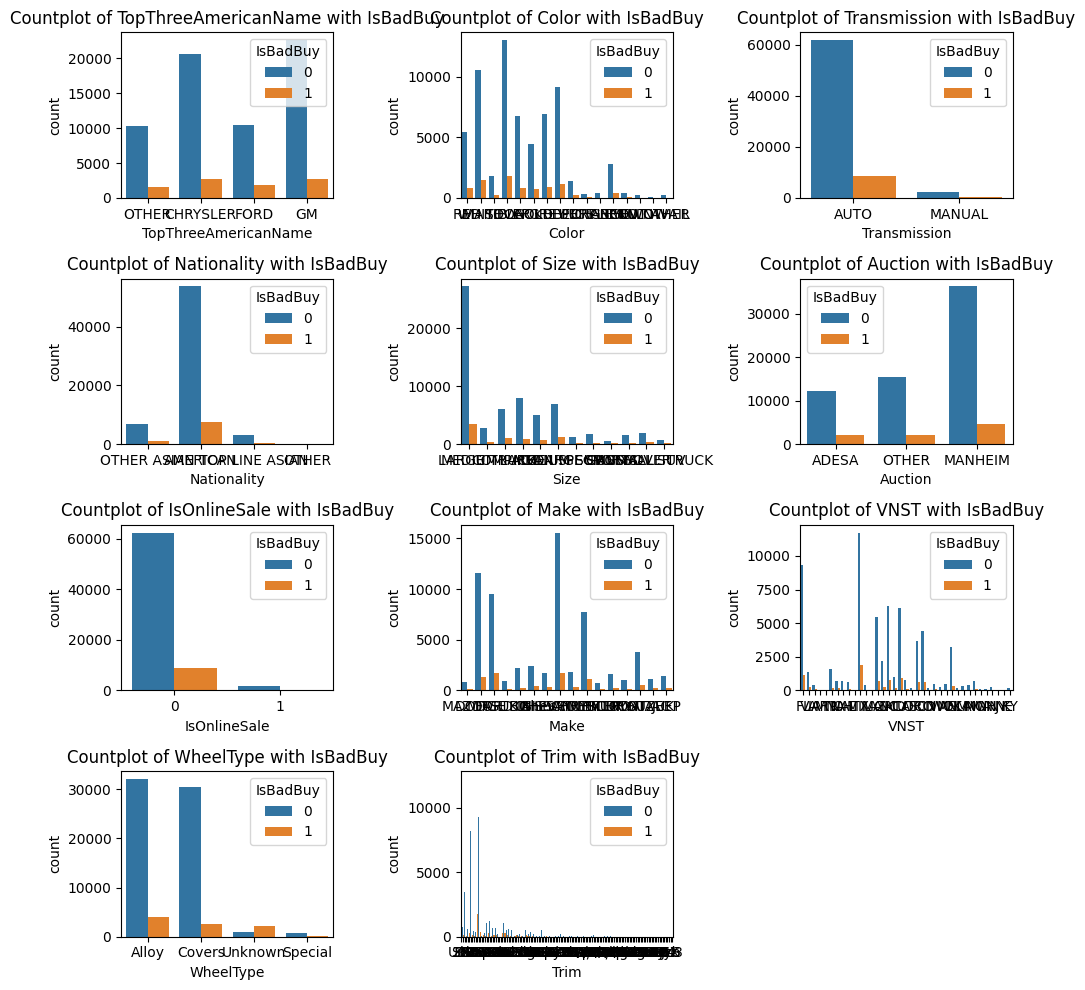

In [ ]:

cat_features = df_clean[['TopThreeAmericanName', 'Color', 'Transmission',
       'Nationality', 'Size', 'Auction', 'IsOnlineSale', 'Make', 'VNST',
        'WheelType','Trim','IsBadBuy']]

fig, axes = plt.subplots(4, 3, figsize=(10, 10))  # Create a 4x3 grid of subplots

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot the countplot for each column with hue
for i, column in enumerate(cat_features.columns[:-1]):  # Exclude the last column (hue column)
    sns.countplot(data=cat_features, x=column, hue='IsBadBuy', ax=axes[i])  # Assign the subplot
    axes[i].set_title(f"Countplot of {column} with IsBadBuy")  # Set the title of the subplot

# Remove any unused subplots
for j in range(len(cat_features.columns)-1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

The above distribution of numerical featuers look more normal after winsorizing the data to deal with outliers. It noticed that the distribution of numerical features are similar by types of isBadBuy but categorical features are different, indicating the categorical features may be more useful to predict isBadBuy.

Transform categorical features

In [ ]:
# to encode categorcal features


cat_columns=[ 'TopThreeAmericanName', 'Color', 'Transmission',
                 'Nationality', 'Size','Auction', 'IsOnlineSale', 'Make',  'VNST', 'WheelType']
cat_transformer = make_column_transformer((category_encoders.CountEncoder(),['Trim']), # frequency encoding

                                             (OneHotEncoder(sparse_output=False), cat_columns),  # one-hot encoding

                                            remainder='passthrough' )



## Modeling and Evaluation


Since we are dealing with a binary classification problem with the target feature (IsBadBuy), there are various ML algorithms to consider, such as logistic regression, random forest, gradient boosting, XGBoost, and MLP. To establish a baseline, I created a dummy classifier as the baseline and a 'userful' ML model should perform better than the baseline. Logistic regression and XGBoost chosen and conducted hyperparameter tuning.

Given the imbalanced nature of the target feature, where the majority class dominates, ML algorithms may exhibit a bias towards the majority class. To address this, I employed down-sampling and balanced class labels during training by specifying class weights if feasible. Since the number of features relatvely large after encoding, I used the regularization (L1/L2) and/or other hypeterparemter that can control overfitting. Additionally, feature normalization was performed to prepare the data for logistic regression.

Regarding evaluation metrics, the primary goal of this project is to predict whether a car purchased at the auction is a "Kick" (bad buy). Bad buys result in revenue loss for auto dealers, so it is crucial to identify as many bad buys as possible. Therefore, recall is a critical metric to consider, as an increase in the recall score can lead to increased revenue by increasing the true positives and reducing the false negatives. There is a trade-off between precision and recall. To account for both precision and recall, the F1 score is also considered. Accuracy is not appropriate for imbalanced classification problems. The ROC AUC is valuable and used for comparing different models as it indicates the classifier's overall prediction ability, regardless of the classification threshold.

Since precision and recall scores are influenced by the classification threshold, threshold tuning was conducted to select the optimal threshold for achieving the desired recall score while maintaining an acceptable precision score.

### Split train and test sets

In [ ]:
#split train and test sets (stratified split based on target)
from sklearn.model_selection import train_test_split

target='IsBadBuy'
y=df[target]
X=df[num_cols+cat_cols+res_cols]
# create train test split
X_train, X_test, y_train, y_test = train_test_split( X,  y, test_size=0.3, stratify=y,random_state=0)

In [ ]:
print(X_train.shape)
X_test.shape

(51088, 23)


(21895, 23)

In [ ]:
print(y_train.value_counts(normalize=True)) #imbalacned labels in the train and test set
y_test.value_counts(normalize=True)

0    0.877016
1    0.122984
Name: IsBadBuy, dtype: float64


0    0.877004
1    0.122996
Name: IsBadBuy, dtype: float64

### Build pipeline to train model

In [ ]:
def build_ml_pipeline(classifier):

    steps = [

          ('prep',   Preprocessor()),
           ('CTN' ,cat_transformer),
           ('minMax', MinMaxScaler()),
         ('model', classifier)]

    pipe=Pipeline(steps)
    return pipe

#### Baseline model: Dummy classifier

In [ ]:
# use the 'stratified' rule. The predictions are generated randomly, however, the distribution of classes from the training set is preserved.
dummy=DummyClassifier(strategy='stratified', random_state=42)
model=dummy.fit(X_train, y_train)

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred=model.predict(X_test)

#### Model Evaluation

In [ ]:
acc = accuracy_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
pre = precision_score(y_train, y_train_pred)
rec = recall_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)

print("Model evaluation result on train data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on train data: 
F1 Score : 12.0401%
ROC AUC : 49.8573%
Accuracy : 78.3785%
Precision : 12.0478%
Recall : 12.0325%


In [ ]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 12.9331%
ROC AUC : 50.3476%
Accuracy : 78.5385%
Precision : 12.9068%
Recall : 12.9595%


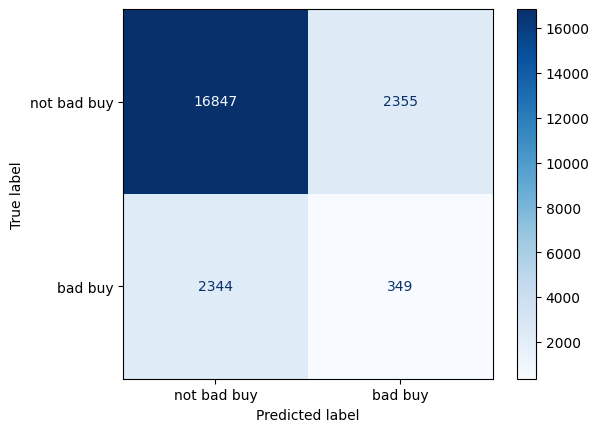

In [ ]:
cm=confusion_matrix(y_test, y_test_pred)

# plot_confusion_matrix function is used to visualize the confusion matrix
ConfusionMatrixDisplay(cm,display_labels = ["not bad buy","bad buy"]).plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:

target_names = ['not bad buy', 'bad buy']
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

 not bad buy       0.88      0.88      0.88     19202
     bad buy       0.13      0.13      0.13      2693

    accuracy                           0.79     21895
   macro avg       0.50      0.50      0.50     21895
weighted avg       0.79      0.79      0.79     21895



The dummy classifier model that makes predictions without trying to find patterns in the data. It shows that recall, precision and F-1 scores (for the minority class) are very low (~12%) in the dummpy classifier. The precision, recall and F1-score are much better in the marjority class than the minority class, which is common for imbalanced classification. The AUC is 50%.

### Model selection with cross validation

In [ ]:
 counter = Counter(y)
 class_weight=counter[0]/counter[1]


In [ ]:
classifiers = [
    LogisticRegression(class_weight='balanced',max_iter=500),
    RandomForestClassifier(class_weight='balanced'),
    GradientBoostingClassifier(),
    XGBClassifier(scale_pos_weight=class_weight,
           n_jobs=-1)
    ]

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True)
for classifier in classifiers:
  pipeline = build_ml_pipeline(classifier)
  %time scores = cross_val_score(pipeline, X_train,y_train, cv=skfold, scoring='roc_auc')
  print(classifier.__class__.__name__, ': AUC is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('==============')

CPU times: user 30.9 s, sys: 6.43 s, total: 37.3 s
Wall time: 28.6 s
LogisticRegression : AUC is 75.023 (0.699)
CPU times: user 51.8 s, sys: 384 ms, total: 52.2 s
Wall time: 54.2 s
RandomForestClassifier : AUC is 73.244 (0.631)
CPU times: user 2min 24s, sys: 205 ms, total: 2min 24s
Wall time: 2min 26s
GradientBoostingClassifier : AUC is 75.618 (0.639)
CPU times: user 20.5 s, sys: 178 ms, total: 20.7 s
Wall time: 15.5 s
XGBClassifier : AUC is 72.939 (0.603)


The results indicate that logistic regression and gradient boosting outperform random forest and XGB. Given its fast training speed and ease of interpretation, I have decided to use logistic regression as the preferred model. However, it is worth noting that other models may perform exceptionally well after hyperparameter tuning, especailly XGBoost. XGBoost is also fast to trian. So that I trained the XGB and also conducted the hyperparameter tuning.

### Logsitic Regression





In [ ]:
pipeline = build_ml_pipeline(LogisticRegression(class_weight='balanced',max_iter=500)) # LR tends to only predict the majority class data so balance class distribution
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep', <__main__.Preprocessor object at 0x7ee07f363e80>),
                ('CTN',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('countencoder',
                                                  CountEncoder(combine_min_nan_groups=True),
                                                  ['Trim']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['TopThreeAmericanName',
                                                   'Color', 'Transmission',
                                                   'Nationality', 'Size',
                                                   'Auction', 'IsOnlineSale',
                                                   'Make', 'VNST',
                                                   'WheelType'])])),
                ('minMax', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [ ]:
#prediction
y_train_pred = pipeline.predict(X_train)
y_test_pred=pipeline.predict(X_test)

#### Evaluation

Train set

In [ ]:
acc = accuracy_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
pre = precision_score(y_train, y_train_pred)
rec = recall_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)

In [ ]:
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 36.8547%
ROC AUC : 68.6037%
Accuracy : 74.2366%
Precision : 26.3787%
Recall : 61.1332%


Test set

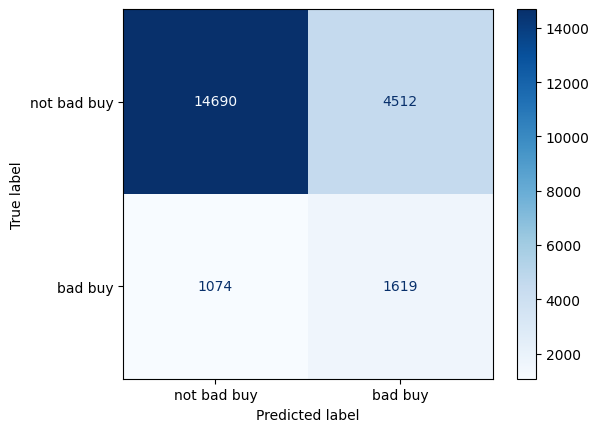

In [ ]:

cm=confusion_matrix(y_test, y_test_pred)

# plot_confusion_matrix function is used to visualize the confusion matrix
ConfusionMatrixDisplay(cm,display_labels = ["not bad buy","bad buy"]).plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

In [ ]:
print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 36.6954%
ROC AUC : 68.3106%
Accuracy : 74.4873%
Precision : 26.4068%
Recall : 60.1188%


In [ ]:
target_names = ['not bad buy', 'bad buy']
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

 not bad buy       0.93      0.77      0.84     19202
     bad buy       0.26      0.60      0.37      2693

    accuracy                           0.74     21895
   macro avg       0.60      0.68      0.60     21895
weighted avg       0.85      0.74      0.78     21895



#### Hypeterparameter tunning for logistic regression

In [ ]:


param_dist = {
    'model__penalty' : ['l1','l2', 'elasticnet','None'],
    'model__C'       : np.logspace(-3, 3, 7),
    'model__solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'model__max_iter': [300,500,1000]
}

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True)

random_search =RandomizedSearchCV(build_ml_pipeline(LogisticRegression(class_weight='balanced')), cv=skfold, param_distributions=param_dist, scoring='roc_auc')
random_search.fit(X_train, y_train)

#search = BayesSearchCV(build_ml_pipeline(LogisticRegression(class_weight='balanced')), search_spaces=param_grid, scoring = 'recall',n_jobs=-1, cv=skfold)
#search.fit(X_train, y_train)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge

20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._f

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              <__main__.Preprocessor object at 0x7ee07c3e7be0>),
                                             ('CTN',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('countencoder',
                                                                               CountEncoder(combine_min_nan_groups=True),
                                                                               ['Trim']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(sparse_output=False),
                                                                               ['Top...
                                                                                'VNST',
                                                                                'WheelType'])])),
                                             ('minMax', MinMaxScaler()),
                                             ('model',
                                              LogisticRegression(class_weight='balanced'))]),
                   param_distributions={'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'model__max_iter': [300, 500, 1000],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet',
                                                           'None'],
                                        'model__solver': ['newton-cg', 'lbfgs',
                                                          'liblinear',
                                                          'saga']},
                   scoring='roc_auc')

In [ ]:
print("Best AUC is %.3f" % random_search.best_score_)
print("Params are %s" % random_search.best_params_)

Best AUC is 0.750
Params are {'model__solver': 'saga', 'model__penalty': 'l1', 'model__max_iter': 300, 'model__C': 0.1}


#### Re-train the logisic regression using optimal hyperparameters

In [ ]:
pipeline = build_ml_pipeline(LogisticRegression( #logisitc regression
    C=0.1,
    penalty='l1',
    solver='saga',
    max_iter=300,
    class_weight='balanced'
))
model_s=pipeline.fit(X_train, y_train)

In [ ]:
y_train_pred = model_s.predict(X_train)
y_test_pred=model_s.predict(X_test)

#### Model Evaluation

Train set

In [ ]:
acc = accuracy_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
pre = precision_score(y_train, y_train_pred)
rec = recall_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 36.9151%
ROC AUC : 68.4903%
Accuracy : 74.6379%
Precision : 26.5923%
Recall : 60.3374%


Test set

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 37.0633%
ROC AUC : 68.5316%
Accuracy : 74.9029%
Precision : 26.7970%
Recall : 60.0817%


In [ ]:
from sklearn.metrics import classification_report
target_names = ['not bad buy', 'bad buy']
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

 not bad buy       0.93      0.77      0.84     19202
     bad buy       0.27      0.60      0.37      2693

    accuracy                           0.75     21895
   macro avg       0.60      0.69      0.61     21895
weighted avg       0.85      0.75      0.79     21895



#### feature importance

In [ ]:
pipeline[0].fit_transform(X_train).columns

Index(['MMR_avg', 'TopThreeAmericanName', 'Color', 'Transmission',
       'Nationality', 'Size', 'Auction', 'IsOnlineSale', 'Make', 'VNST',
       'VehOdo', 'VehicleAge', 'WheelType', 'Trim', 'WarrantyCost', 'VehBCost',
       'miles_per_year'],
      dtype='object')

In [ ]:
res_names=list(set(pipeline[0].fit_transform(X_train).columns) - set(cat_columns))
res_names.remove('Trim')
ohe_names=list(pipeline[1].named_transformers_['onehotencoder'].get_feature_names_out(cat_columns))
tot_names=['Trim']+ohe_names+res_names
#mask=pipeline[3].get_support()
#selected_names = np.array(tot_names)[mask]


In [ ]:

print(pipeline.steps[3][1].intercept_)
pipeline.steps[3][1].coef_


[-1.11498695]


array([[ 3.78540006e-02,  5.38679889e-03,  0.00000000e+00,
        -2.13914754e-01,  0.00000000e+00, -8.67792569e-02,
         0.00000000e+00, -8.66813576e-02,  0.00000000e+00,
         3.77037132e-02, -1.86823660e-01, -2.49449722e-02,
         1.93020072e-02,  0.00000000e+00,  0.00000000e+00,
        -6.86029311e-01,  2.17130640e-02,  0.00000000e+00,
         1.11189544e-02,  0.00000000e+00,  0.00000000e+00,
         6.13072882e-02, -3.07040781e-02,  0.00000000e+00,
         0.00000000e+00,  1.01931772e-03, -6.88253427e-02,
         1.32884301e-01,  0.00000000e+00, -1.24330035e-01,
         3.14672764e-01,  0.00000000e+00, -9.23929624e-02,
         1.38962036e-01, -8.55642506e-02,  0.00000000e+00,
         2.19076233e-01,  2.24599709e-01, -1.40494873e-01,
         0.00000000e+00,  1.83210840e-01, -1.13353087e-01,
         0.00000000e+00,  0.00000000e+00, -1.78932107e-01,
         5.64553894e-03, -1.49797294e-01, -9.38442379e-02,
        -3.43539650e-03,  1.75649162e-01,  0.00000000e+0

               feature  importance
100  WheelType_Unknown    3.301975
103       WarrantyCost    1.533078
105         VehicleAge    1.309698
106             VehOdo    1.119898
102     miles_per_year    1.059738
..                 ...         ...
76             VNST_MN    0.000000
35    Size_SMALL TRUCK    0.000000
31    Size_LARGE TRUCK    0.000000
80             VNST_NE    0.000000
28      Size_CROSSOVER    0.000000

[107 rows x 2 columns]


<Figure size 1600x2000 with 0 Axes>

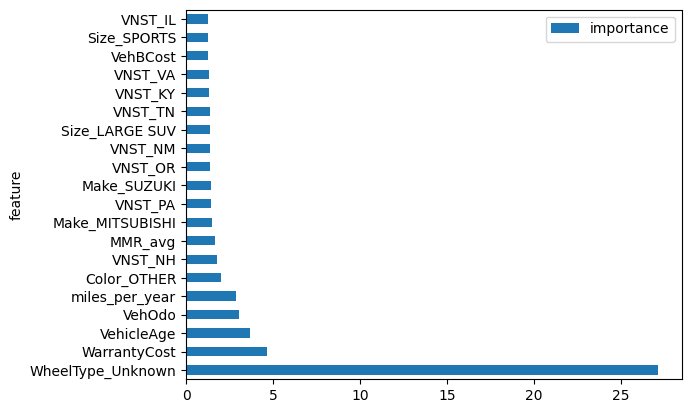

In [ ]:
feature_names=tot_names
importances=abs(pipeline.steps[3][1].coef_)
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances.flatten()}).sort_values("importance", ascending=False)
print(df_importances)

# get feature importance
plt.figure(figsize = (16,20))
weight=np.transpose(importances)
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, weight) # odds ratio
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance[:20].plot.barh(x='feature', y='importance')
plt.show()

#### Threshold tuning to achieve a higher recall (logisitc regression)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

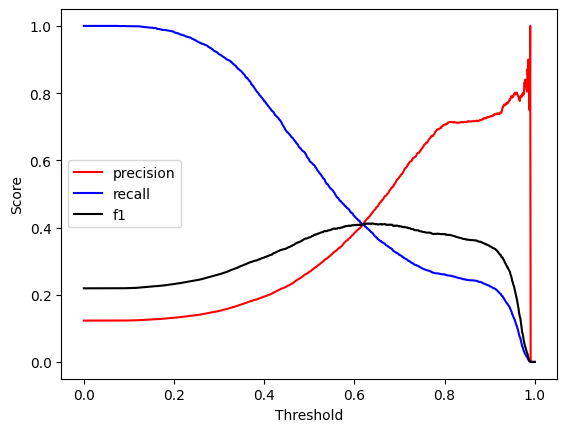

threshold for 65% recall: 0.472
precison score at 65% recall: 0.243


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred_prob=model_s.predict_proba(X_test)[:,1]
thresholds = np.linspace(0, 1, 1000)
precisions = []
recalls = []
f1s = []
ave = "binary"

for cut in thresholds:
    y_test_predic = (y_pred_prob > cut).astype(int)
    precisions.append(precision_score(y_test, y_test_predic, average=ave))
    recalls.append(recall_score(y_test, y_test_predic, average=ave))
    f1s.append(f1_score(y_test, y_test_predic, average=ave))

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

index=np.argmin(np.array(recalls) >= 0.65)
thr_65_recall = round(thresholds[index], ndigits = 3)
pre_65_recall =round(precisions[index], ndigits = 3)
print('threshold for 65% recall:', thr_65_recall)
print('precison score at 65% recall:',pre_65_recall)

The results show the logisitc regression model perform much better than the dummy classifier based on all the metrics (recall, precision, F1-score and ROC AUC). Recall score for the minority class improved a lot compared to the dummy classifier (0.60 vs. 0.12).

### XGBoost

In [ ]:
pipeline2 = build_ml_pipeline( XGBClassifier(scale_pos_weight=class_weight,
           n_jobs=-1))
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('prep', <__main__.Preprocessor object at 0x7ee07c249240>),
                ('CTN',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('countencoder',
                                                  CountEncoder(combine_min_nan_groups=True),
                                                  ['Trim']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['TopThreeAmericanName',
                                                   'Color', 'Transmission',
                                                   'Nationality', 'Size',
                                                   'Auction', 'IsOnlineSale',
                                                   'Ma...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

#### Evaluation

In [ ]:
y_train_pred = pipeline2.predict(X_train)
y_test_pred=pipeline2.predict(X_test)

Train set

In [ ]:
acc = accuracy_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
pre = precision_score(y_train, y_train_pred)
rec = recall_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)


print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 57.2015%
ROC AUC : 83.6841%
Accuracy : 84.8947%
Precision : 43.8968%
Recall : 82.0786%


Test set

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 36.5428%
ROC AUC : 66.6371%
Accuracy : 77.9356%
Precision : 28.2724%
Recall : 51.6524%


#### Hyperparamter Tunning

In [ ]:
param_dist = {
    'model__max_depth': [3,5,10],
    'model__eta': [0.01, 0.1,0.5],
    'model__subsample': [0.6, 0.8, 1],
    'model__n_estimators':[100, 300],
    'model__reg_lambda': [0.001,0.1,1,10],
    'model__reg_alpha':[0.001,0.1,1,10]
}

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True)

random_search =RandomizedSearchCV(build_ml_pipeline( XGBClassifier(scale_pos_weight=class_weight,
           n_jobs=-1)) , cv=skfold, param_distributions=param_dist, scoring='roc_auc')
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              <__main__.Preprocessor object at 0x7ee07c24a080>),
                                             ('CTN',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('countencoder',
                                                                               CountEncoder(combine_min_nan_groups=True),
                                                                               ['Trim']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(sparse_output=False),
                                                                               ['Top...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   param_distributions={'model__eta': [0.01, 0.1, 0.5],
                                        'model__max_depth': [3, 5, 10],
                                        'model__n_estimators': [100, 300],
                                        'model__reg_alpha': [0.001, 0.1, 1, 10],
                                        'model__reg_lambda': [0.001, 0.1, 1,
                                                              10],
                                        'model__subsample': [0.6, 0.8, 1]},
                   scoring='roc_auc')

In [ ]:
print("Best AUC is %.3f" % random_search.best_score_)
print("Params are %s" % random_search.best_params_)

Best AUC is 0.757
Params are {'model__subsample': 0.8, 'model__reg_lambda': 10, 'model__reg_alpha': 0.001, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__eta': 0.1}


#### Retrain XGBoost

In [ ]:
pipeline2 = build_ml_pipeline(XGBClassifier(scale_pos_weight=class_weight,
            max_depth= 3,
            eta=0.1,
            subsample=0.8,
            n_estimators=100,
             reg_lambda=10,
              reg_alpha=0.001,

           n_jobs=-1))
model_s=pipeline2.fit(X_train, y_train)

In [ ]:
y_train_pred = model_s.predict(X_train)
y_test_pred=model_s.predict(X_test)

Train set

In [ ]:
acc = accuracy_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
pre = precision_score(y_train, y_train_pred)
rec = recall_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 38.2575%
ROC AUC : 69.5602%
Accuracy : 75.5305%
Precision : 27.7356%
Recall : 61.6425%


Test set

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 37.2260%
ROC AUC : 68.5376%
Accuracy : 75.2775%
Precision : 27.0658%
Recall : 59.5990%


#### feature importance

In [ ]:
res_names=list(set(pipeline2[0].fit_transform(X_train).columns) - set(cat_columns))
res_names.remove('Trim')
ohe_names=list(pipeline2[1].named_transformers_['onehotencoder'].get_feature_names_out(cat_columns))
tot_names=['Trim']+ohe_names+res_names
#mask=pipeline[3].get_support()
#selected_names = np.array(tot_names)[mask]
selected_names=tot_names

               feature  importance
100  WheelType_Unknown    0.323283
103       WarrantyCost    0.120743
105         VehicleAge    0.029575
40     Auction_MANHEIM    0.020796
44      Make_CHEVROLET    0.018805
..                 ...         ...
73             VNST_MA    0.000000
75             VNST_MI    0.000000
76             VNST_MN    0.000000
77             VNST_MO    0.000000
72             VNST_LA    0.000000

[107 rows x 2 columns]


<Figure size 1600x2000 with 0 Axes>

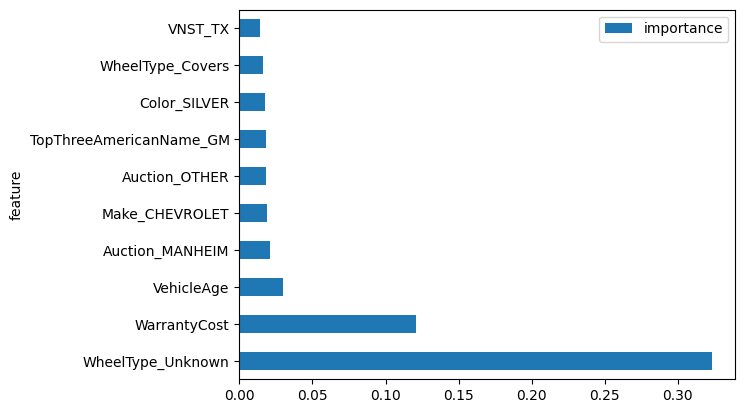

In [ ]:
feature_names=selected_names
importances=model_s.steps[3][1].feature_importances_
df_importances = pd.DataFrame(
    {"feature":feature_names, "importance":importances.flatten()}).sort_values("importance", ascending=False)
print(df_importances)

# get feature importance
plt.figure(figsize = (16,20))
weight=np.transpose(importances)
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = weight
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
ax = feature_importance[:10].plot.barh(x='feature', y='importance')
plt.show()

In [ ]:
feature_importance

,feature,importance
100,WheelType_Unknown,0.323283
103,WarrantyCost,0.120743
105,VehicleAge,0.029575
40,Auction_MANHEIM,0.020796
44,Make_CHEVROLET,0.018805
...,...,...
73,VNST_MA,0.000000
75,VNST_MI,0.000000
76,VNST_MN,0.000000
77,VNST_MO,0.000000


SHAP values

[18:28:27] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


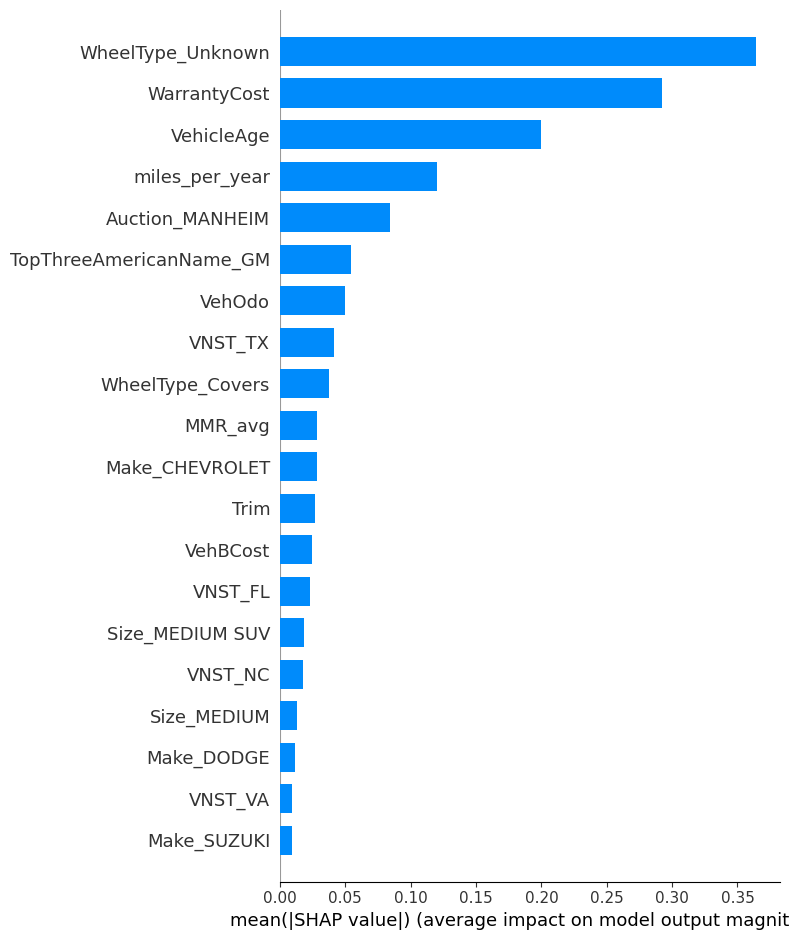

In [ ]:
# Fits the explainer
shap.initjs()
explainer = shap.TreeExplainer(model_s['model'])
obsers0 = pipeline2[0].transform(X_test)
obsers1 = pipeline2[1].transform(obsers0)
obsers2=pipeline2[2].transform(obsers1)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(obsers2)

#plot the feature importance, gloabl shap
shap.summary_plot(shap_values, selected_names, plot_type="bar")

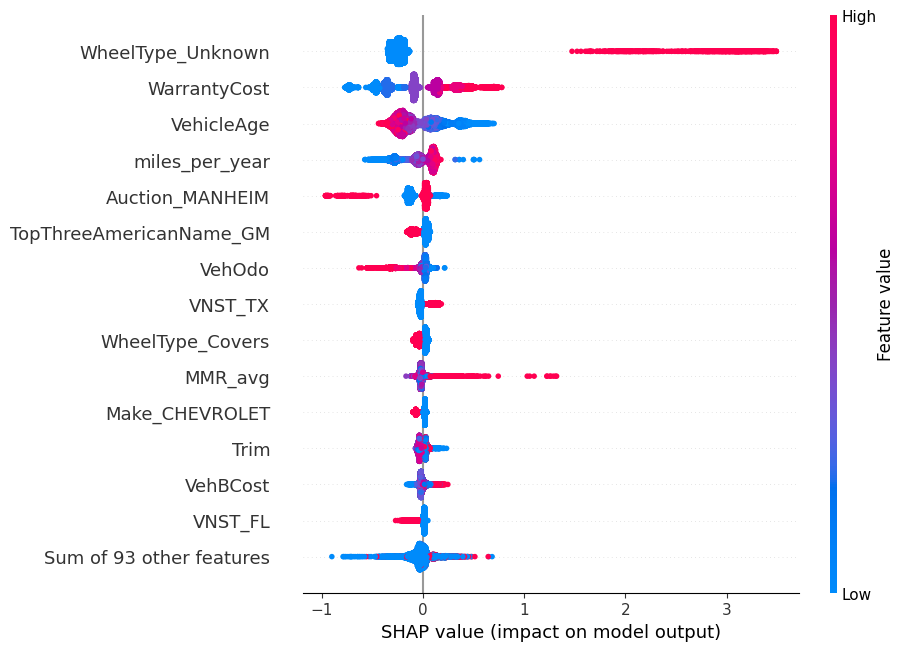

In [ ]:
#global beeswarm plot

#sv=explainer.shap_values(obsers2)
#get_feature_names_out()
explanation=shap.Explanation(values=shap_values,data=obsers2,feature_names=feature_names)
shap.plots.beeswarm(explanation,max_display=15)

In [ ]:
X_test_df=pd.DataFrame(obsers2,columns=feature_names)
sv=explainer(X_test_df)

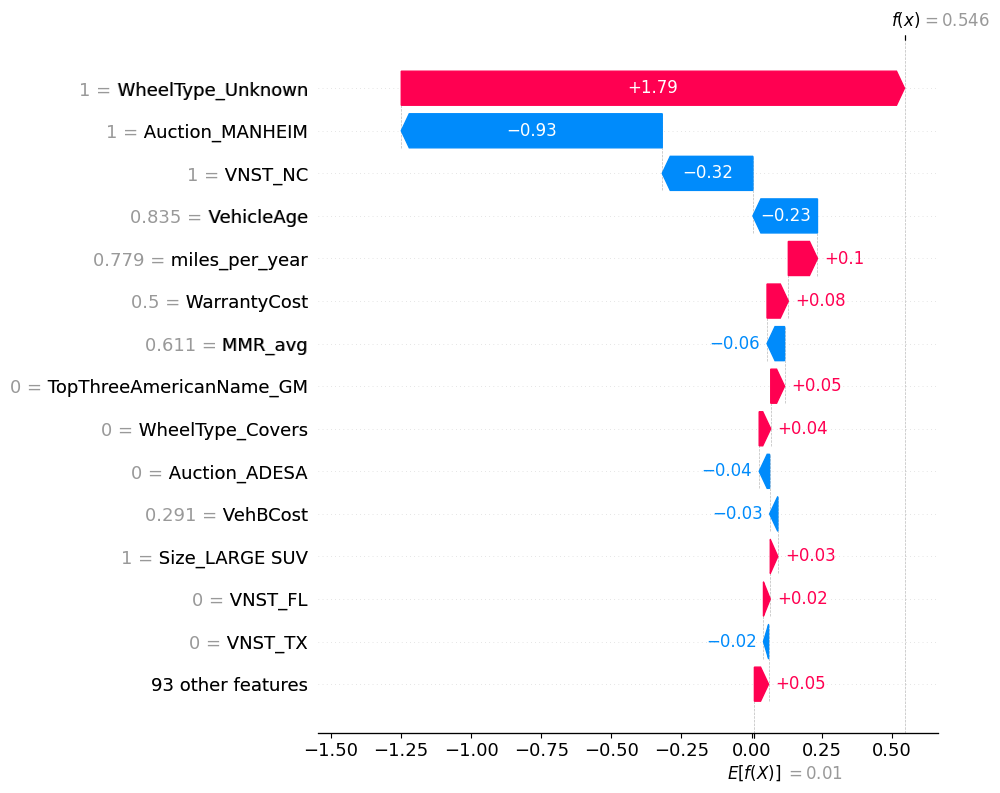

In [ ]:
#SHAP for single instance
shap.plots.waterfall(sv[0],max_display=15) # pred =1, bad buy

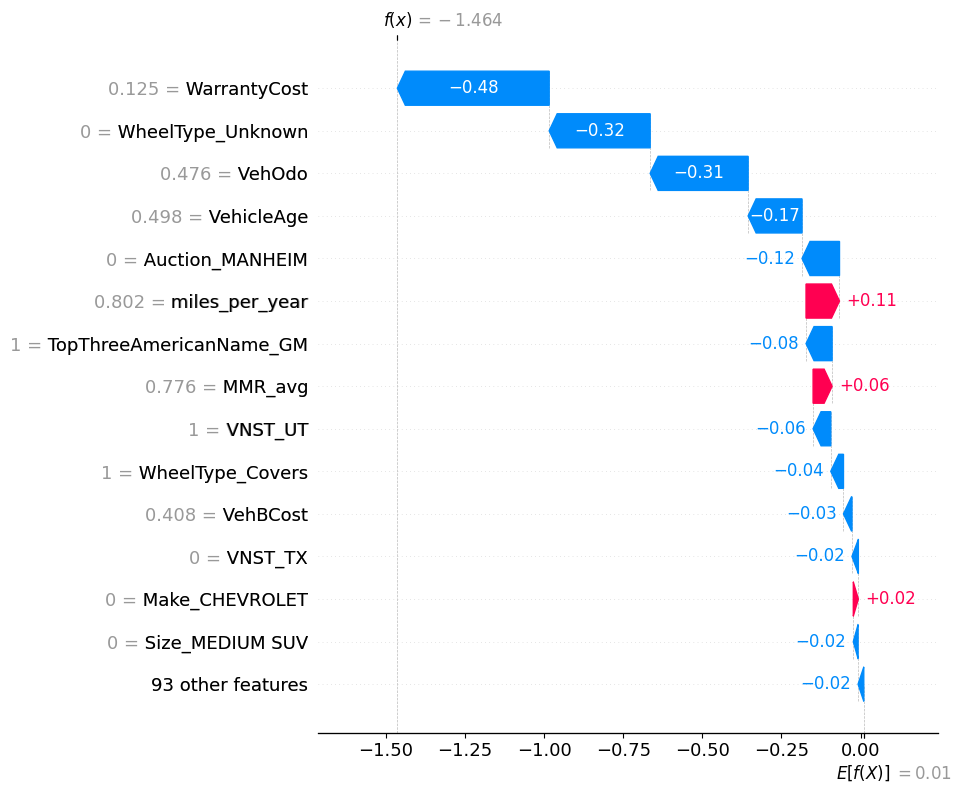

In [ ]:
#SHAP for single instance
shap.plots.waterfall(sv[1],max_display=15) # pred =0, not bad buy


#### Threshold tuning to get a higher recall

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

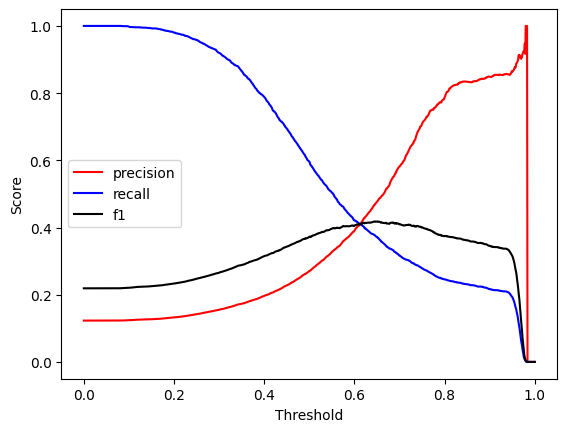

threshold for 65% recall: 0.473
precison score at 65% recall: 0.247


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred_prob=model_s.predict_proba(X_test)[:,1]
thresholds = np.linspace(0, 1, 1000)
precisions = []
recalls = []
f1s = []
ave = "binary"

for cut in thresholds:
    y_test_predic = (y_pred_prob > cut).astype(int)
    precisions.append(precision_score(y_test, y_test_predic, average=ave))
    recalls.append(recall_score(y_test, y_test_predic, average=ave))
    f1s.append(f1_score(y_test, y_test_predic, average=ave))

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

index=np.argmin(np.array(recalls) >= 0.65)
thr_65_recall = round(thresholds[index], ndigits = 3)
pre_65_recall =round(precisions[index], ndigits = 3)
print('threshold for 65% recall:', thr_65_recall)
print('precison score at 65% recall:',pre_65_recall)

### Drop 'WheelType' and re-trian the XGBoost

In [ ]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

In [ ]:
cat_columns2=[ 'TopThreeAmericanName', 'Color', 'Transmission',
                 'Nationality', 'Size','Auction', 'IsOnlineSale', 'Make',  'VNST']
cat_transformer2 = make_column_transformer((category_encoders.CountEncoder(),['Trim']), # frequency encoding

                                             (OneHotEncoder(sparse_output=False), cat_columns2),  # one-hot encoding

                                            remainder='passthrough' )


In [ ]:
def build_ml_pipeline2(classifier):

    steps = [

          ('prep',   Preprocessor()),
            ("columnDropper", columnDropperTransformer(['WheelType'])),
           ('CTN' ,cat_transformer2),
           ('minMax', MinMaxScaler()),
         ('model', classifier)]

    pipe=Pipeline(steps)
    return pipe

In [ ]:
param_dist = {
    'model__max_depth': [3,5,10],
    'model__eta': [0.01, 0.1,0.5],
    'model__subsample': [0.6, 0.8, 1],
    'model__n_estimators':[100, 300],
    'model__reg_lambda': [0.001,0.1,1,10],
    'model__reg_alpha':[0.001,0.1,1,10]
}

In [ ]:
skfold = StratifiedKFold(n_splits=5, shuffle=True)

random_search =RandomizedSearchCV(build_ml_pipeline2( XGBClassifier(scale_pos_weight=class_weight,
           n_jobs=-1)) , cv=skfold, param_distributions=param_dist, scoring='roc_auc')
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('prep',
                                              <__main__.Preprocessor object at 0x7ee07eaaea70>),
                                             ('columnDropper',
                                              <__main__.columnDropperTransformer object at 0x7ee07eaae770>),
                                             ('CTN',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('countencoder',
                                                                               CountEncoder(combine_min_nan_grou...
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   param_distributions={'model__eta': [0.01, 0.1, 0.5],
                                        'model__max_depth': [3, 5, 10],
                                        'model__n_estimators': [100, 300],
                                        'model__reg_alpha': [0.001, 0.1, 1, 10],
                                        'model__reg_lambda': [0.001, 0.1, 1,
                                                              10],
                                        'model__subsample': [0.6, 0.8, 1]},
                   scoring='roc_auc')

In [ ]:
print("Best AUC is %.3f" % random_search.best_score_)
print("Params are %s" % random_search.best_params_)

Best AUC is 0.673
Params are {'model__subsample': 1, 'model__reg_lambda': 0.1, 'model__reg_alpha': 10, 'model__n_estimators': 100, 'model__max_depth': 5, 'model__eta': 0.1}


In [ ]:
pipeline3 = build_ml_pipeline2(XGBClassifier(scale_pos_weight=class_weight,
            max_depth= 5,
            eta=0.1,
            subsample=1,
            n_estimators=100,
             reg_lambda=0.1,
            reg_alpha=10,
           n_jobs=-1))
model_s=pipeline3.fit(X_train, y_train)

In [ ]:
y_train_pred = model_s.predict(X_train)
y_test_pred=model_s.predict(X_test)

In [ ]:
acc = accuracy_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
pre = precision_score(y_train, y_train_pred)
rec = recall_score(y_train, y_train_pred)
auc = roc_auc_score(y_train, y_train_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 34.0207%
ROC AUC : 67.8348%
Accuracy : 67.3074%
Precision : 22.6262%
Recall : 68.5341%


In [ ]:
acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
pre = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

print("Model evaluation result on test data: ")
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

Model evaluation result on test data: 
F1 Score : 29.7762%
ROC AUC : 62.9125%
Accuracy : 65.4670%
Precision : 19.8539%
Recall : 59.5247%


In [ ]:
res_names=list(set(pipeline3[0].fit_transform(X_train).columns) - set(cat_columns2))
res_names.remove('Trim')
res_names.remove('WheelType')
ohe_names=list(pipeline3[2].named_transformers_['onehotencoder'].get_feature_names_out(cat_columns2))
tot_names=['Trim']+ohe_names+res_names

[18:51:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


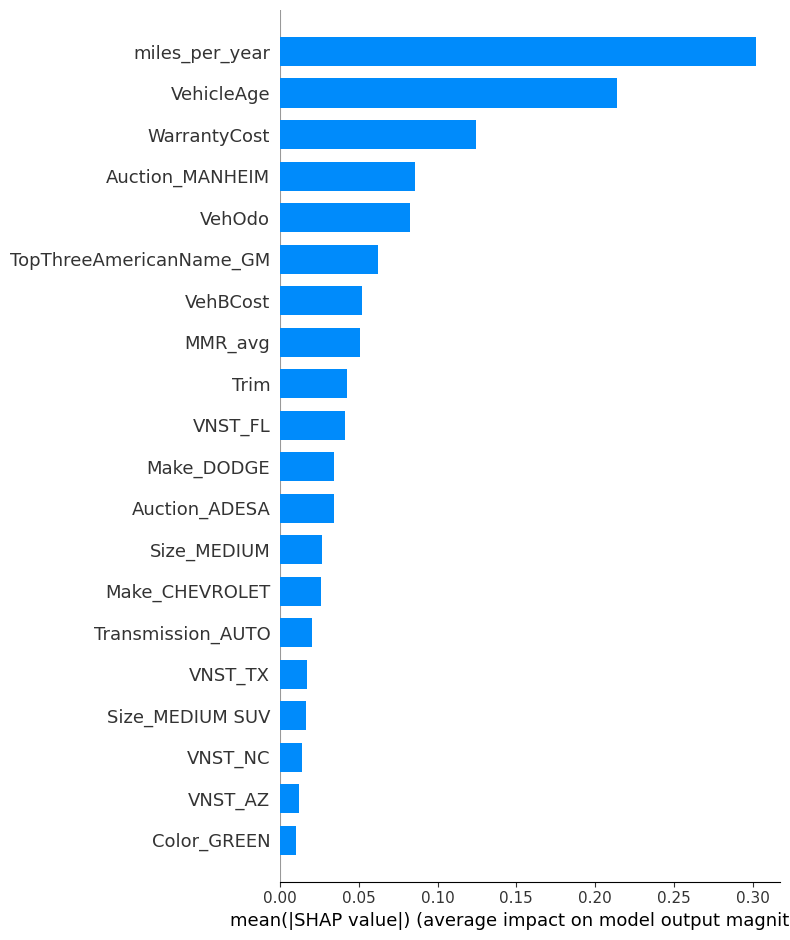

In [ ]:
# Fits the explainer

shap.initjs()
explainer = shap.TreeExplainer(model_s['model'])
obsers0 = pipeline3[0].transform(X_test)
obsers1 = pipeline3[1].transform(obsers0)
obsers2=pipeline3[2].transform(obsers1)
obsers3 = pipeline3[3].transform(obsers2)

#get Shap values from preprocessed data
shap_values = explainer.shap_values(obsers3)

#plot the feature importance
shap.summary_plot(shap_values, tot_names, plot_type="bar")

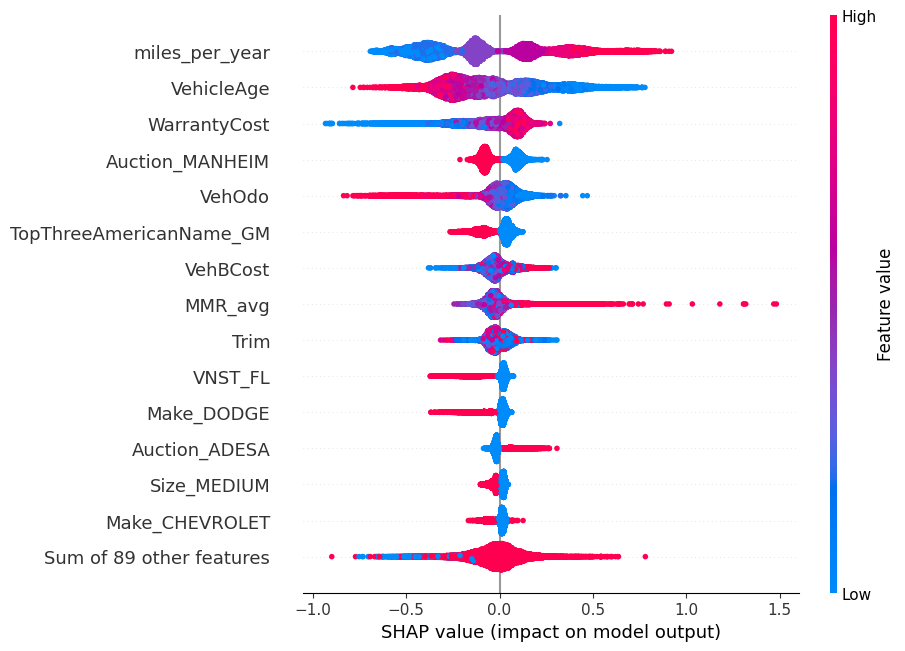

In [ ]:

#sv=explainer.shap_values(obsers2)
#get_feature_names_out()
explanation=shap.Explanation(values=shap_values,data=obsers3,feature_names=tot_names)
shap.plots.beeswarm(explanation,max_display=15)

**Summary**


| Scores (Test set) | Logisitc Regression | XGBoost | Dummy Classifier|
| :---         |     :---:      |          ---: |    ---: |
| AUC    |   68.53%    |     68.54%| 50.35%|
| Recall   |    60.08%   |      59.60%|  12.96%|
| Precision at 65% recall   |    24.3 %   |     24.7%| - |
| Precision   |    26.80%   |      27.07%|  12.91%|
| F1 score   |    37.06%   |      37.23%|  12.93%|
| Top features   |   WheelType_Unknown, WarrantyCost,  <br> VehicleAge,VehOdo, miles_per_year   |    WheelType_unknown, WarrantyCost, <br> VehicleAge, miles_per_year, Auction_MANHEIM| - |





In summary, this project addresses the challenge faced by auto dealerships when purchasing used cars at auto auctions, where some cars turn out to be 'kicks' and cannot be sold to customers. These kicks result in revenue loss for dealers. To mitigate this issue, I developed a 'kicks' detector using historical data to predict which cars are at a higher risk of being kicks and captured important features that contributed to 'kicks'.

The logistic regression model significantly improved the recall score by approximately 360% (60% vs. 13%) compared to a dummy classifier,  and increased the ROC AUC about 38% (0.69 vs. 0.5).  It is important to note that recall and precision scores depend on the threshold and there is a trade-off between them. For instance, setting the threshold at 0.47  can achieve a recall score of 65% and precision score of 24.3%. The increase in the recall score (increased TP and reduced FN) directly contributes to increased revenue.

XGBoost performed very similar to logisitc regression and it had the potentional to achieve a hgiher score by feature engineering and hyperparameter tuning. Logisitc regression is easier to interpret (coef estimates are odds ratios)

The top six features that contribute to the risk of being a kick are  WheelType_unknown, WarrantyCost, VehicleAge, miles_per_year, Auction_MANHEIM and TopThreeAmericanName_GM (XGBoost). It appears WheelType is an important features, but the WheelType_Unknown lacks informative value since it represents missing entries filled with 'Unknown'. The XGBoost model trained without 'WheelType' feature had worse performance. It would be beneficial to gather additional information about the 'WheelType' or use other similar features as proxy. It may also help to examine other features for the cars with unknown WheelType, to see if can identify some patterns.

Recommedentations:
* pay attention to WheelType
* pay attention to warranty cost
* pay attention to miles_per_year



Moving forward, there are several aspects to consider for further improvements:

* Explore better approaches for handling missing values, such as trying different imputation strategies.
* Explore additional features such as purchase date, model, submodel, and creating new features based on the number of cylinders, injection types, driving system, and body information from model/submodel.
* Seek input from domain experts to identify and create other potentially useful features.
* Explore different feature selection strategies such as Recursive Feature Elimination with Cross-Validation (RFECV).
* Try fine-tune other hyperparameters in XGBoost that may future increase the model performance
* Try other modeling appraoches such as lightGBM, CatBoost and stacking.
* Design a new metric based on counts of TP, FP and FN and the revenue and cost associated with them. Tune the classification threshold to achieve an optimal revenue.




Post-hoc analysis to examine the characteristics among cars with unknown WheelType versus those with known WheelType.

In [ ]:
df_selected=X_test[X_test['WheelType'].isnull()==True]
df_unselected=X_test[X_test['WheelType'].isnull()==False]
df_selected.columns

Index(['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
       'TopThreeAmericanName', 'Color', 'Transmission', 'Nationality', 'Size',
       'Auction', 'IsOnlineSale', 'Make', 'VNST', 'VehOdo', 'VehicleAge',
       'WheelType', 'Trim', 'WarrantyCost', 'VehBCost'],
      dtype='object')

In [ ]:
df_selected=X_test[X_test['WheelType'].isnull()==True]
df_unselected=X_test[X_test['WheelType'].isnull()==False]
print(df_selected.VehOdo.describe())
print(df_unselected.VehOdo.describe())
stats.ttest_ind(df_selected.VehOdo,df_unselected.VehOdo, equal_var=False)

count       963.000000
mean      72723.743510
std       14503.936668
min       23327.000000
25%       62972.000000
50%       74630.000000
75%       83792.000000
max      107476.000000
Name: VehOdo, dtype: float64
count     20932.000000
mean      71408.238439
std       14595.222658
min        8706.000000
25%       61878.500000
50%       73235.500000
75%       82310.000000
max      115717.000000
Name: VehOdo, dtype: float64


TtestResult(statistic=2.7512629314774784, pvalue=0.006038389328463986, df=1053.6162673765702)

In [ ]:
import scipy.stats as stats
print(df_selected.VehBCost.describe())
print(df_unselected.VehBCost.describe())
stats.ttest_ind(df_selected.VehBCost,df_unselected.VehBCost, equal_var=False)

count      963.000000
mean      6442.422638
std       1779.470527
min       2570.000000
25%       5082.500000
50%       6400.000000
75%       7700.000000
max      11800.000000
Name: VehBCost, dtype: float64
count    20932.000000
mean      6747.807114
std       1763.578796
min       1720.000000
25%       5458.750000
50%       6740.000000
75%       7900.000000
max      38785.000000
Name: VehBCost, dtype: float64


TtestResult(statistic=-5.2092125775250695, pvalue=2.2813591764093735e-07, df=1050.8075764060088)

In [ ]:
print(df_selected.Auction.value_counts())

df_unselected.Auction.value_counts()


ADESA      363
OTHER      349
MANHEIM    251
Name: Auction, dtype: int64


MANHEIM    12069
OTHER       4844
ADESA       4019
Name: Auction, dtype: int64

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
table = [ [363, 349, 251],
 [12069,  4844,  4019]]
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
prob = 0.95
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
 print('Dependent (reject H0)')
else:
 print('Independent (fail to reject H0)')

[[363, 349, 251], [12069, 4844, 4019]]
dof=2
significance=0.050, p=0.000
Dependent (reject H0)
